<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [2.3 Logical Modeling and Generalized Disjunctive Programs](https://ndcbe.github.io/CBE60499/02.03-GDP.html) | [Contents](toc.html) | [2.5 Numeric Integration for DAEs](https://ndcbe.github.io/CBE60499/02.05-Numeric-Integration.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.04-DAE-modeling.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.04-DAE-modeling.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.4 Dynamic Optimization: Differential Algebraic Equations (DAEs)

In [1]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    !pip install casadi
    helper.install_idaes()
    #helper.install_ipopt()

## 2.4.1 Dynamic Optimization Overview

**Chapter 8: Dynamic Optimization Introduction** (Biegler, 2010)
-	Chemical engineering examples
-	Classical (variational) approaches including Hamiltonian and Euler-Lagrange equations
-	DAE background (this notebook)

**Chapter 9: Sequential Methods** (Biegler, 2010)
-	DAE integration (this notebook, next notebook)
-	Single Shooting
-	Multiple Shooting

**Chapter 10: Simultaneous Methods** (Biegler, 2010)
-	Gauss quadrature (next notebook)
-	Orthogonal collocation on finite elements (next notebook, next next notebook)
-	Examples, benchmarks, and large-scale extensions

![dynamic-optimization-strategies](./figures/dynamic_optimization_strategies.png)

![sequential_dae_optimization](./figures/sequential_dae_optimization.png)

## 2.4.2 DAE Index Reduction

Excerpts from Chapter 8 of Biegler (2010).

![dae-form1](./figures/dae_form1.png)
![dae-form2](./figures/dae_form2.png)

![dae-reduction](./figures/dae_reduction.png)

## 2.4.3 DAE Formulations for Simple Pendulum Example

Pyomo.dae documentation:
* https://pyomo.readthedocs.io/en/latest/modeling_extensions/dae.html

Pendulum example:
* http://apmonitor.com/wiki/index.php/Apps/PendulumMotion
* https://www.lehigh.edu/~wes1/apci/11may00.pdf

CasADi (need to integrate DAEs):
* https://web.casadi.org/get/
* For local installation: ```pip install casadi```. Warning: installing `CasADi` with `conda` will install an "okay" version of Ipopt. If you really want to install `CasADi` with `conda`, you'll likely need to add `import idaes` to your notebook to load the "good" version of Ipopt (Linux and Windows users).

DAE simulation example:
* https://github.com/Pyomo/pyomo/blob/master/examples/dae/simulator_dae_example.py

In [2]:
## Load libraries
from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator
import matplotlib.pyplot as plt
import numpy as np

## Define function for plotting results
def plot_results(sim, tsim, profiles):

    '''
    time = list(m.t)
    x = [value(m.x[t]) for t in m.t]
    y = [value(m.y[t]) for t in m.t]

    plt.plot(time, x, '-b', label='x')
    plt.plot(time, y, '-r', label='y')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend(loc='best')
    plt.show()
    '''
    
    plt.figure(1)
    varorder = sim.get_variable_order()
    algorder = sim.get_variable_order(vartype='algebraic')

    # Create empty dictionary
    results = {}
    
    for idx1, v in enumerate(varorder):
        i = idx1
        v_ = str(v)
        results[v_] = profiles[:, i]
        plt.plot(tsim, results[v_], label=v)

    for idx2, v in enumerate(algorder):
        i = len(varorder) + idx2
        v_ = str(v)
        results[v_] = profiles[:, i]
        plt.plot(tsim, results[v_], label=v)
    
    plt.xlabel('t')
    plt.legend(loc='best')
    
    plt.show()
    
    plt.figure(2)
    x_ = results['x[{t}]']
    y_ = results['y[{t}]']
    plt.plot(tsim, np.sqrt(x_**2 + y_**2), '-b', label='length')
    plt.xlabel('t')
    plt.ylabel('$\sqrt{x^2 + y^2}$')
    plt.show()
    
    #return results

### 2.4.3.1 Formulation 1: Index-3 DAE

Consider the following model:

$$\begin{align}
\frac{d x}{dt} &= u \\
\frac{d y}{dt} &= v \\
\frac{d u}{dt} &= -T x \\
\frac{d v}{dt} &= g - Ty \\
& x^2 + y^2 = 1
\end{align}$$

This assumes mass and length of unity.

In [3]:
def create_model_index3():

    m = ConcreteModel()

    # Declare time
    m.t = ContinuousSet(bounds=(0.0, 1))

    # Declare parameter - acceleration due to gravity
    m.g = Param(initialize=9.81) # m/s^2

    # Declare variables indexed over time
    m.x = Var(m.t) # horizontal position
    m.y = Var(m.t) # vertical position
    m.u = Var(m.t) # horizontal velocity
    m.v = Var(m.t) # vertical velocity
    m.T = Var(m.t) # tension

    # Declare derivative variables
    m.dx = DerivativeVar(m.x) # with respect to t is implied
    m.dy = DerivativeVar(m.y)
    m.du = DerivativeVar(m.u)
    m.dv = DerivativeVar(m.v)

    # Declare differential equations
    def _dx_eqn(m, t):
        return m.dx[t] == m.u[t]
    m.dx_eqn = Constraint(m.t, rule=_dx_eqn)

    def _dy_eqn(m, t):
        return m.dy[t] == m.v[t]
    m.dy_eqn = Constraint(m.t, rule=_dy_eqn)

    def _du_eqn(m, t):
        return m.du[t] == -m.T[t]*m.x[t]
    m.du_eqn = Constraint(m.t, rule=_du_eqn)

    def _dv_eqn(m, t):
        return m.dv[t] == m.g -m.T[t]*m.y[t]
    m.dv_eqn = Constraint(m.t, rule=_dv_eqn)

    # Declare algebraic equation
    def _alg_eqn(m, t):
        return m.x[t]**2 + m.y[t]**2 == 1
    m.alg_eqn = Constraint(m.t, rule=_alg_eqn)

    # Specify initial conditions
    m.x[0] = 0
    m.y[0] = 1
    m.u[0] = 1
    m.v[0] = 0
    m.T[0] = 1 + m.g
    
    return m

index3 = create_model_index3()

# Specify integrator options
int_ops = {'print_stats':True,"abstol":1E-8,"reltol":1E-6}

# Solve DAEs
sim = Simulator(index3, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)

# Plot solution
plot_results(sim, tsim, profiles)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0 and h = 1.06624e-14, the corrector convergence failed repeatedly or with |h| = hmin.


RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.

**Warning**: If you run this notebook in Colab, you may get the following runtime error and your kernel may crash:

![casadi-error-1](./figures/casadi-error1.png)

![casadi-error-2](./figures/casadi-error2.png)

Why did the `IDAS` integrator in `SUNDIALS` fail? It is only meant for index 0 or 1 DAEs! Integrating high index DAEs is really hard!

### 2.4.3.2 Formulation 2: Pure ODE Model

$$\begin{align}
\frac{d x}{dt} &= u \\
\frac{d y}{dt} &= v \\
\frac{d u}{dt} &= -T x \\
\frac{d v}{dt} &= g - Ty \\
\frac{d T}{dt} &= 4 T (x u + y v) + 3 g v
\end{align}$$


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 167
Number of calls to the user’s f function: 242
Number of calls made to the linear solver setup function: 31
Number of error test failures: 7
Method order used on the last internal step: 5
Method order to be used on the next internal step: 5
Actual value of initial step size: 7.90569e-07
Step size taken on the last internal step: 0.00246466
Step size to be attempted on the next internal step: 0.00492933
Current internal time reached: 0.00492933
Number of nonlinear iterations performed: 240
Number of nonlinear convergence failures: 0



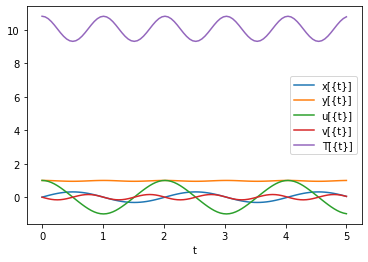

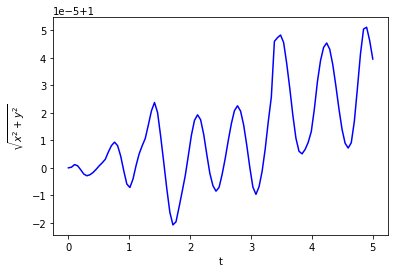

In [4]:
def create_model_ode():

    m = ConcreteModel()

    # Declare time
    m.t = ContinuousSet(bounds=(0.0, 5.0))

    # Declare parameter - acceleration due to gravity
    m.g = Param(initialize=9.81) # m/s^2

    # Declare variables indexed over time
    m.x = Var(m.t) # horizontal position
    m.y = Var(m.t) # vertical position
    m.u = Var(m.t) # horizontal velocity
    m.v = Var(m.t) # vertical velocity
    m.T = Var(m.t) # tension

    # Declare derivative variables
    m.dx = DerivativeVar(m.x) # with respect to t is implied
    m.dy = DerivativeVar(m.y)
    m.du = DerivativeVar(m.u)
    m.dv = DerivativeVar(m.v)
    m.dT = DerivativeVar(m.T)

    # Declare differential equations
    def _dx_eqn(m, t):
        return m.dx[t] == m.u[t]
    m.dx_eqn = Constraint(m.t, rule=_dx_eqn)

    def _dy_eqn(m, t):
        return m.dy[t] == m.v[t]
    m.dy_eqn = Constraint(m.t, rule=_dy_eqn)

    def _du_eqn(m, t):
        return m.du[t] == -m.T[t]*m.x[t]
    m.du_eqn = Constraint(m.t, rule=_du_eqn)

    def _dv_eqn(m, t):
        return m.dv[t] == m.g -m.T[t]*m.y[t]
    m.dv_eqn = Constraint(m.t, rule=_dv_eqn)

    def _dT_eqn(m, t):
        return m.dT[t] == 4*m.T[t]*(m.x[t]*m.u[t] + m.y[t]*m.v[t]) + 3*m.g*m.v[t]
    m.dT_eqn = Constraint(m.t, rule=_dT_eqn)

    # Specify initial conditions
    m.x[0] = 0
    m.y[0] = 1
    m.u[0] = 1
    m.v[0] = 0
    m.T[0] = 1 + m.g
    
    return m

ode = create_model_ode()

# Specify integrator options
int_ops = {'print_stats':True,"abstol":1E-6,"reltol":1E-4}

# Solve DAEs
sim = Simulator(ode, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)

# Plot solution
results = plot_results(sim, tsim, profiles)

**Discussion**
* Are all of the algebraic constraints in the original formulation satisfied?

### 2.4.3.3 Formulation 3: Index-1 DAE Model

$$\begin{align}
\frac{d y}{dt} &= v \\
\frac{d v}{dt} &= g - Ty \\
 & x^2 + y^2 = 1 \\
 & 2 x u + 2 y v = 0 \\
 & (u^2 + v^2) - T (x^2 + y^2) + g y = 0
\end{align}$$

(This reformulation is NOT unique... could have written $\frac{dx}{dt}$ and $\frac{du}{dt}$ instead.)

Consistent initial conditions:
1. Specify $y(0)$ and $v(0)$.
2. Solve for $x(0)$, $u(0)$, and $T(0)$

In [4]:
def create_model_index1():

    m = ConcreteModel()

    # Declare time
    m.t = ContinuousSet(bounds=(0, 5))

    # Declare parameter - acceleration due to gravity
    m.g = Param(initialize=9.81) # m/s^2

    # Declare variables indexed over time
    m.x = Var(m.t) # horizontal position
    m.y = Var(m.t) # vertical position
    m.u = Var(m.t) # horizontal velocity
    m.v = Var(m.t) # vertical velocity
    m.T = Var(m.t) # tension

    # Declare derivative variables
    m.dy = DerivativeVar(m.y)
    m.dv = DerivativeVar(m.v)

    # Declare differential equations
    def _dy_eqn(m, t):
        return m.dy[t] == m.v[t]
    m.dy_eqn = Constraint(m.t, rule=_dy_eqn)

    def _dv_eqn(m, t):
        return m.dv[t] == m.g - m.T[t]*m.y[t]
    m.dv_eqn = Constraint(m.t, rule=_dv_eqn)

    # Declare algebraic equations
    def _alg_eqn1(m, t):
        return m.x[t]**2 + m.y[t]**2 == 1
    m.alg_eqn1 = Constraint(m.t, rule=_alg_eqn1)

    def _alg_eqn2(m, t):
        return m.x[t]*m.u[t] + m.y[t]*m.v[t] == 0
    m.alg_eqn2 = Constraint(m.t, rule=_alg_eqn2)

    def _alg_eqn3(m, t):
        return m.u[t]**2 + m.v[t]**2 - m.T[t]*(m.x[t]**2 + m.y[t]**2) + m.g*m.y[t] == 0
    m.alg_eqn3 = Constraint(m.t, rule=_alg_eqn3)

    # Specify initial conditions
    m.x[0] = 0
    m.y[0] = 1
    m.u[0] = 1
    m.v[0] = 0
    m.T[0] = 1 + m.g
    
    return m

def index1_check_constraints(m):
    """ Check if the three constraints are feasible.
    """
    
    print("Constraint 1:")
    r1 = m.x[0]()**2 + m.y[0]()**2 - 1
    print(r1)
    
    print("\nConstraint 2:")
    r2 = m.x[0]()*m.u[0]() + m.y[0]()*m.v[0]()
    print(r2)
    
    print("\nConstraint 3:")
    r3 = m.u[0]()**2 + m.v[0]()**2 - m.T[0]() + m.g*m.y[0]()
    print(r3)

index1 = create_model_index1()

# Check initial condition
index1_check_constraints(index1)

# Specify integrator options
int_ops = {'print_stats':True,"abstol":1E-6,"reltol":1E-4}

# Solve DAEs
sim = Simulator(index1, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)
# tsim, profiles = sim.simulate(numpoints=100, integrator='collocation')

Constraint 1:
0

Constraint 2:
0

Constraint 3:
0.0


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.


RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_NO_RECOVERY". Consult IDAS documentation.

What happened? Point singularity at $x=0$.

Let's try $x=0.1$ as the initial point.

In [5]:
index1_again = create_model_index1()

# Specify alternative initial conditions
small_number = 0.1

index1_again.x[0] = small_number
index1_again.y[0] = 1
index1_again.u[0] = 1
index1_again.v[0] = 0
index1_again.T[0] = 1 + index1_again.g

# Check initial condition
index1_check_constraints(index1_again)

# Solve DAEs
sim = Simulator(index1_again, package='casadi')

# Simulator
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)

Constraint 1:
0.010000000000000009

Constraint 2:
0.1

Constraint 3:
0.0


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.


RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_NO_RECOVERY". Consult IDAS documentation.

Our initial point does not satisfy the algebraic constraints! We need a consistent initial point.

Given $x = \epsilon$, solve $x^2 + y^2 = 1$ for $y$:

$$ y = \sqrt{1^2 - \epsilon^2}$$

Then, assume $u = 1$ and solve $2 x u + 2 y v = 0$ for $v$:

$$v = \frac{-x u}{y}$$

Finally, we can solve $(u^2 + v^2) - T (x^2 + y^2) + g y = 0$ for $T$:

$$
T = \frac{(u^2 + v^2) + gy}{x^2 + y^2} = \frac{(u^2 + v^2) + gy}{1}
$$

In [6]:
index1_take_two = create_model_index1()

# Specify alternative initial conditions
small_number = 0.1

index1_take_two.x[0] = small_number
index1_take_two.y[0] = np.sqrt(1 - small_number**2)
index1_take_two.u[0] = 1
index1_take_two.v[0] = -index1_take_two.x[0]()*index1_take_two.u[0]()/index1_take_two.y[0]()
index1_take_two.T[0] = (index1_take_two.u[0]()**2 + index1_take_two.v[0]()**2
    + index1_take_two.g*index1_take_two.y[0]())

# Check initial condition
index1_check_constraints(index1_take_two)

# Solve DAEs
sim = Simulator(index1_take_two, package='casadi')

# Specify integrator options
int_ops2 = {'print_stats':True,"abstol":1E-6,"reltol":1E-4,
            "verbose":False,"calc_ic":True}

# Simulator
tsim, profiles = sim.simulate(numpoints=20, integrator='idas',integrator_options=int_ops2)

Constraint 1:
0.0

Constraint 2:
0.0

Constraint 3:
0.0


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.


RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_NO_RECOVERY". Consult IDAS documentation.

### 2.4.3.4 Formulation 4: Index-1 DAE Model

$$\begin{align}
\frac{d x}{dt} &= u \\
\frac{d y}{dt} &= v \\
\frac{d u}{dt} &= -T x \\
\frac{d v}{dt} &= g - Ty \\
0 &= (u^2 + v^2) - T (x^2 + y^2) + g y
\end{align}$$

Consistent initial conditions:
1. Specify $x(0)$, $u(0)$, $y(0)$, and $v(0)$.
2. Solve for $T(0)$

In [7]:
def create_model_index1_b():

    m = ConcreteModel()
    
    # Declare time
    m.t = ContinuousSet(bounds=(0.0, 5))

    # Declare parameter - acceleration due to gravity
    m.g = Param(initialize=9.81) # m/s^2

    # Declare variables indexed over time
    m.x = Var(m.t) # horizontal position
    m.y = Var(m.t) # vertical position
    m.u = Var(m.t) # horizontal velocity
    m.v = Var(m.t) # vertical velocity
    m.T = Var(m.t) # tension

    # Declare derivative variables
    m.dx = DerivativeVar(m.x) # with respect to t is implied
    m.dy = DerivativeVar(m.y)
    m.du = DerivativeVar(m.u)
    m.dv = DerivativeVar(m.v)

    # Declare differential equations
    def _dx_eqn(m, t):
        return m.dx[t] == m.u[t]
    m.dx_eqn = Constraint(m.t, rule=_dx_eqn)

    def _dy_eqn(m, t):
        return m.dy[t] == m.v[t]
    m.dy_eqn = Constraint(m.t, rule=_dy_eqn)

    def _du_eqn(m, t):
        return m.du[t] == -m.T[t]*m.x[t]
    m.du_eqn = Constraint(m.t, rule=_du_eqn)

    def _dv_eqn(m, t):
        return m.dv[t] == m.g -m.T[t]*m.y[t]
    m.dv_eqn = Constraint(m.t, rule=_dv_eqn)

    def _alg_eqn3(m, t):
        return m.u[t]**2 + m.v[t]**2 - m.T[t]*(m.x[t]**2 + m.y[t]**2) + m.g*m.y[t] == 0
    m.alg_eqn3 = Constraint(m.t, rule=_alg_eqn3)

    # Specify initial conditions
    m.x[0] = 0
    m.y[0] = 1
    m.u[0] = 1
    m.v[0] = 0
    m.T[0] = 1 + m.g
    
    return m

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 379
Number of calls to the user’s f function: 485
Number of calls made to the linear solver setup function: 31
Number of error test failures: 3
Method order used on the last internal step: 5
Method order to be used on the next internal step: 5
Actual value of initial step size: 7.90569e-09
Step size taken on the last internal step: 0.0120795
Step size to be attempted on the next internal step: 0.0120795
Current internal time reached: 0.0120795
Number of nonlinear iterations performed: 483
Number of nonlinear convergence failures: 0



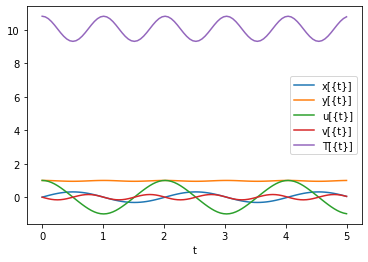

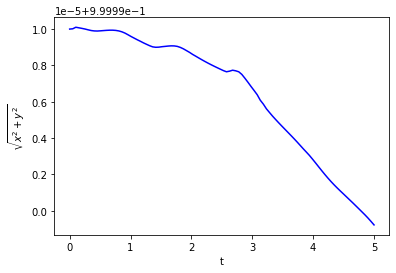

In [8]:
index1_b = create_model_index1_b()

# Specify integrator options
int_ops = {'print_stats':True,"abstol":1E-8,"reltol":1E-6}

# Solve DAEs
sim = Simulator(index1_b, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)

# Plot solution
plot_results(sim, tsim, profiles)

## 2.4.4 Take Away Messages
1. Differential algebriac equations (DAEs) are really powerful modeling tools.
2. Integrating DAEs requires special care. Make sure your model is index 1.
3. Often there are many ways to reformulate the DAE model. But the numeric integrator only enforces error tolerances on the equations that are explicitly modeled. If an algebriac constraint must be satified to a specific tolerance, include it in the DAE model (as long as it is not high index!).

<!--NAVIGATION-->
< [2.3 Logical Modeling and Generalized Disjunctive Programs](https://ndcbe.github.io/CBE60499/02.03-GDP.html) | [Contents](toc.html) | [2.5 Numeric Integration for DAEs](https://ndcbe.github.io/CBE60499/02.05-Numeric-Integration.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.04-DAE-modeling.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.04-DAE-modeling.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>